In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, v_measure_score, completeness_score, homogeneity_score,f1_score,confusion_matrix,accuracy_score,ConfusionMatrixDisplay # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN # а также другие алгоритмы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [3]:
from my_awesome_eda import run_eda

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [5]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """

    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels,
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)

    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

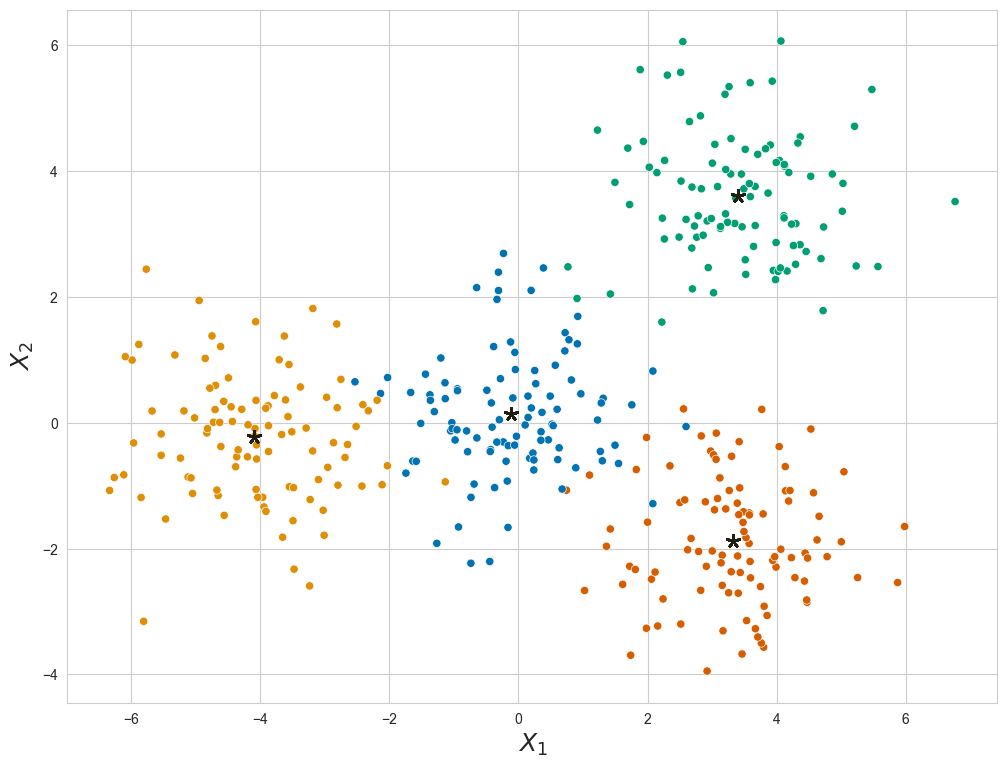

In [6]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [7]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=100, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """

        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
        self.dist_list = []


    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """

        n_samples, n_features = X.shape

        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples),
                                             size=self.n_clusters,
                                             replace=False)
            centroids = X[centroids_idx]

        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []

            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)

            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)

            self.dist_list.append(centroids)

            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

        self.centroids = np.array(centroids)

        return self


    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """


        dist = np.linalg.norm(X - self.centroids[0,:],axis=1).reshape(-1,1)
        for class_ in range(1,self.n_clusters):
            dist = np.append(dist,np.linalg.norm(X - self.centroids[class_,:],axis=1).reshape(-1,1),axis=1)
        cluster_labels = np.argmin(dist,axis=1)

        return cluster_labels


    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """

        dist = np.linalg.norm(X - centroid,axis=1).reshape(-1,1)

        return dist


    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

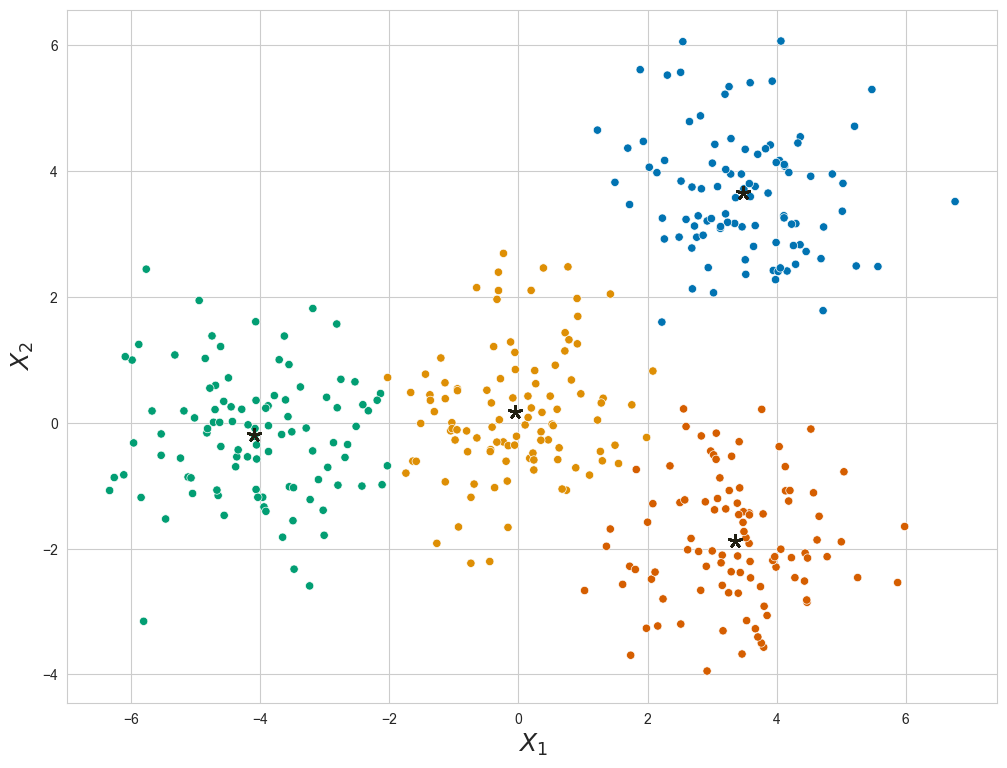

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
kmeans = MyKMeans(n_clusters=4, init="random", max_iter=10, visualize=True)
kmeans.fit(X)

In [9]:
for ind, arr in enumerate(kmeans.dist_list):
    if ind == 0:
      prev = arr
    else:
      if np.array_equal(prev, arr):
        print(f'The optimum was at {ind + 1} ittartion')
        break;
      prev = arr

The optimum was at 6 ittartion


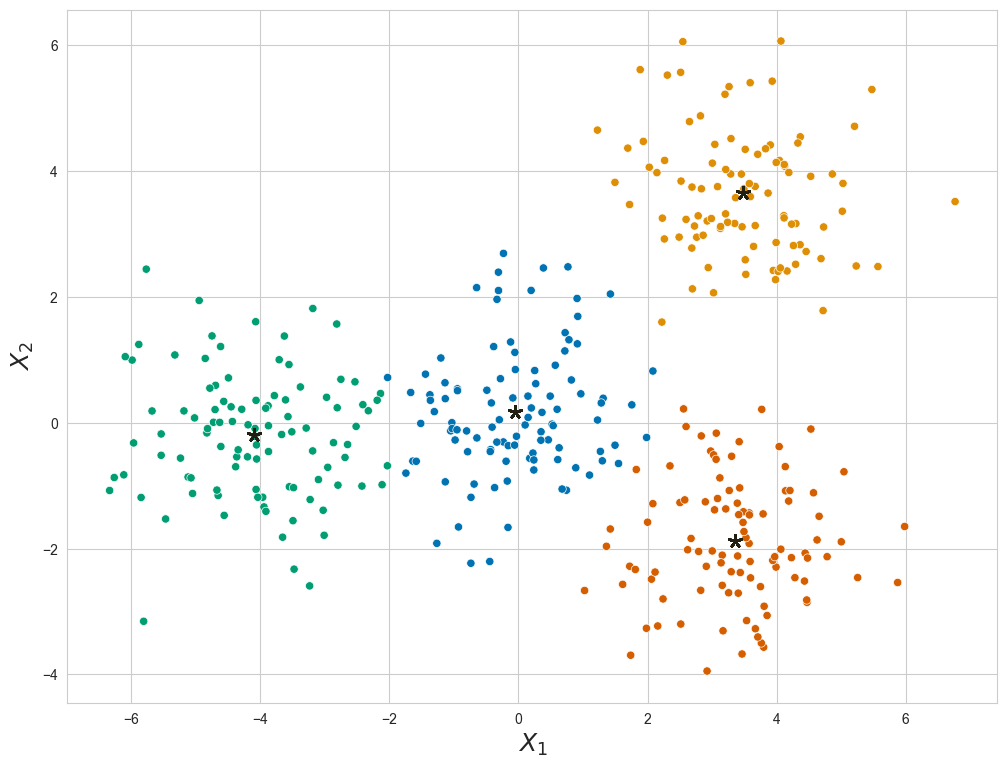

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [10]:
kmeans2 = MyKMeans(n_clusters=4, init="sample", max_iter=10, visualize=True)
kmeans2.fit(X)

In [11]:
for ind, arr in enumerate(kmeans2.dist_list):
    if ind == 0:
      prev = arr
    else:
      if np.array_equal(prev, arr):
        print(f'The optimum was at {ind + 1} ittartion')
        break;
      prev = arr

The optimum was at 7 ittartion


Видно, что при выборе метода 'sample' (выбирает центроиды случайно из объектов выборки) на нашей выборке центроиды нашлись на 2 иттерации быстрее.

Проверим рабочесть нашей функции predict:

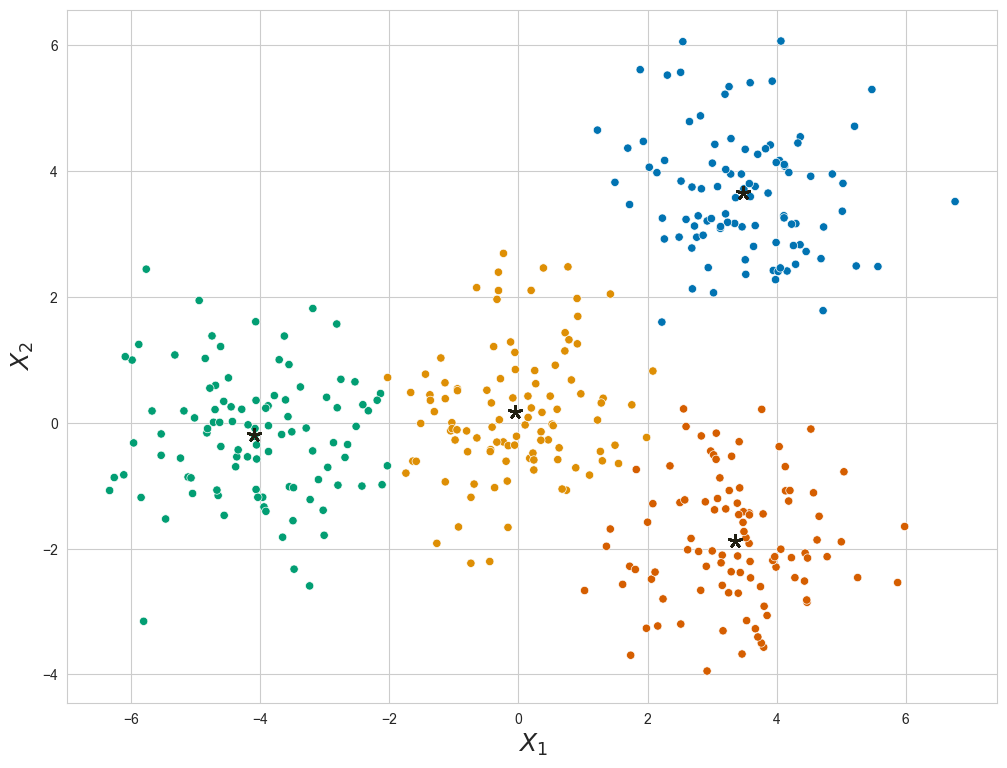

In [12]:
classes = kmeans.predict(X)
visualize_clusters(X, classes)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [13]:
data = load_digits()
X, y = data.data, data.target

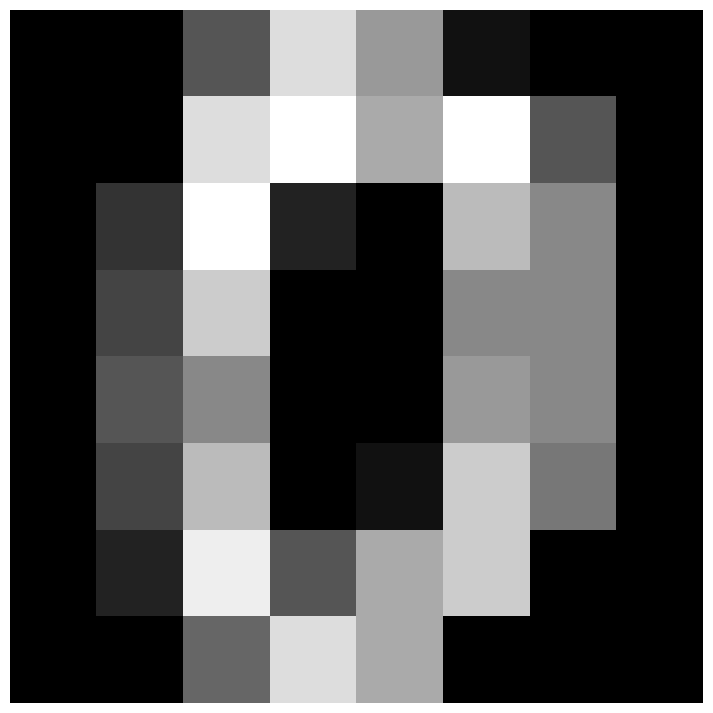

In [14]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [15]:
def algorithm_selection(X, y, distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
                        algorithms = ['average', 'single', 'complete']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    rows_list = []
    for metric_dist in distances:
        for linkage in algorithms:
            clustering = AgglomerativeClustering(n_clusters=10, metric=metric_dist,linkage=linkage).fit(X)
            y_pred = clustering.labels_

            h_s = homogeneity_score(y, y_pred)
            c_s = completeness_score(y, y_pred)
            v_s = v_measure_score(y, y_pred)
            s_s = silhouette_score(X, y_pred,metric=metric_dist)

            rows_list.append([metric_dist,linkage,h_s,c_s,v_s,s_s])

    compare_dataframe = pd.DataFrame(rows_list, columns=['distance', 'linkage', 'homogenity', 'completeness', 'v_measure', 'silhouette'])

    return compare_dataframe

In [16]:
compare_dataframe=algorithm_selection(X,y)
compare_dataframe.sort_values(['silhouette', 'v_measure', 'completeness', 'homogenity'], ascending=False)

distance   linkage  homogenity  completeness  v_measure  silhouette
12     cosine   average    0.648268      0.808762   0.719676    0.218229
5          l1  complete    0.646372      0.686109   0.665648    0.160617
11  manhattan  complete    0.646372      0.686109   0.665648    0.160617
0   euclidean   average    0.655393      0.782342   0.713263    0.146625
6          l2   average    0.655393      0.782342   0.713263    0.146625
14     cosine  complete    0.528727      0.577415   0.551999    0.144179
2   euclidean  complete    0.590549      0.637772   0.613253    0.119271
8          l2  complete    0.590549      0.637772   0.613253    0.119271
3          l1   average    0.566751      0.778942   0.656117    0.105238
9   manhattan   average    0.566751      0.778942   0.656117    0.105238
1   euclidean    single    0.005056      0.273755   0.009929   -0.133621
7          l2    single    0.005056      0.273755   0.009929   -0.133621
4          l1    single    0.005102      0.276237   0.010019   -0.203816
10  manhattan    single    0.005102      0.276237   0.010019   -0.203816
13     cosine    single    0.005050      0.273389   0.009916   -0.281789

In [17]:
#сделаьь  выводы

Все метрики, кроме homogenity ведут себя достаточно согласованно. homogenity показывает наибольший скор для linkage = average, как и остальные метрики, но при этом показывает что лушче брать расстояния euclidean или l2. При этом homogenity и completeness могут давать высокие значения, если объекты класса случайно распределены по кластерам.

В любом случае согласно общей оценке по метрикам лучший алгоритм иерархической кластеризации - average. Это логично, так как метод средней связи  вычисляет среднее расстояние между всеми парами точек из двух кластеров и по сути является компромиссом между одиночной и полной связью.

По приведенным метрикам лучший параметр для рассчета расстояния - cosine


### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [18]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [19]:
print(f'Кол-во клеток {fc_data.shape[0]}, кол-во признаков {fc_data.shape[1]}')

fc_data.describe()

Кол-во клеток 10000, кол-во признаков 9


FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

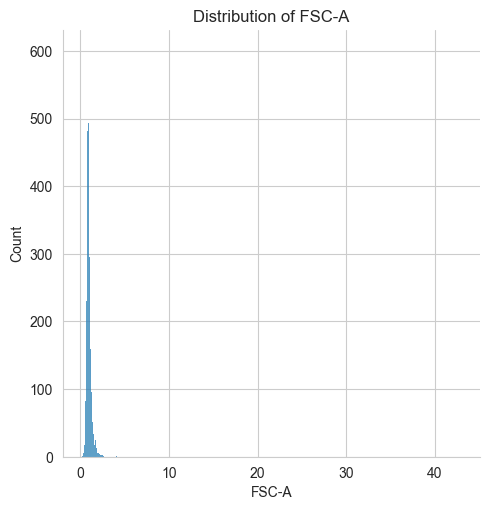

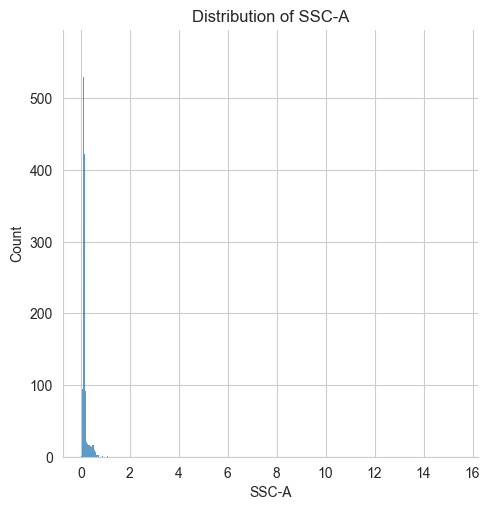

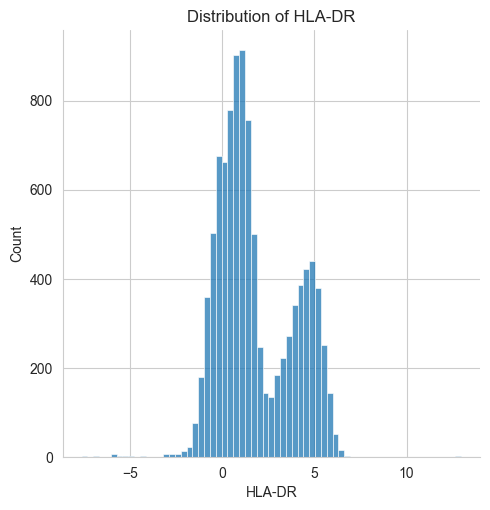

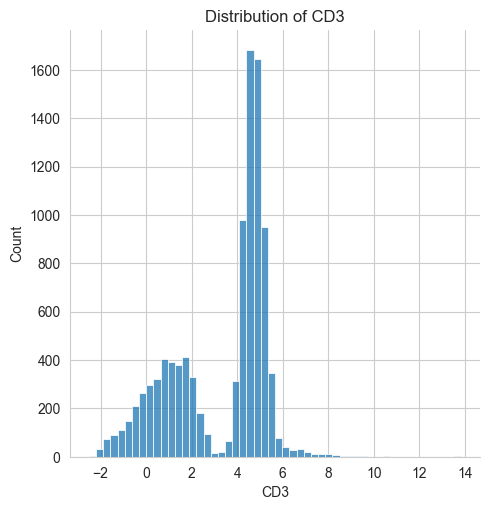

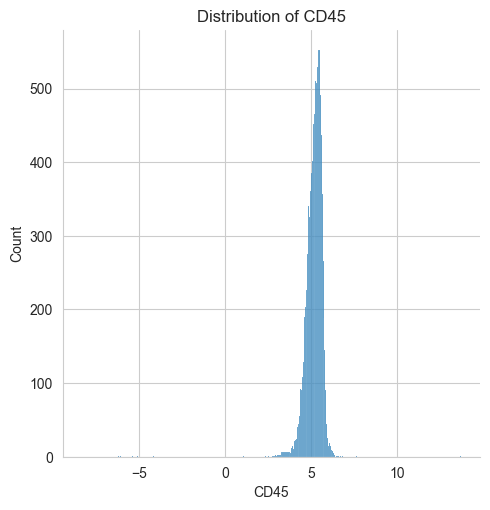

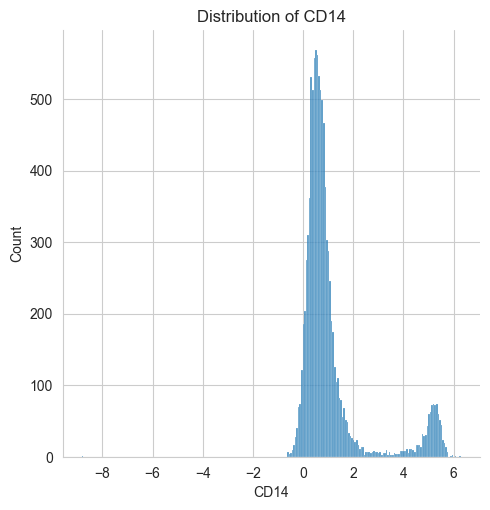

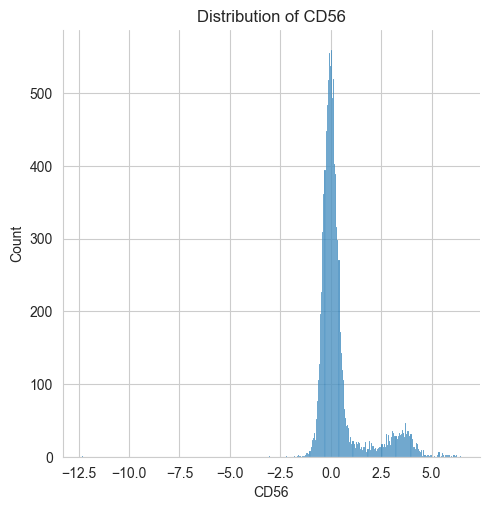

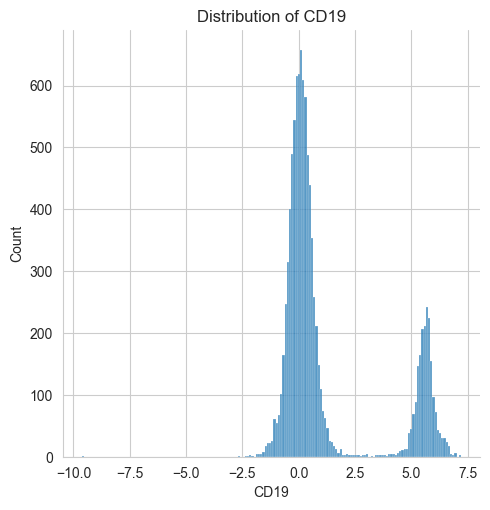

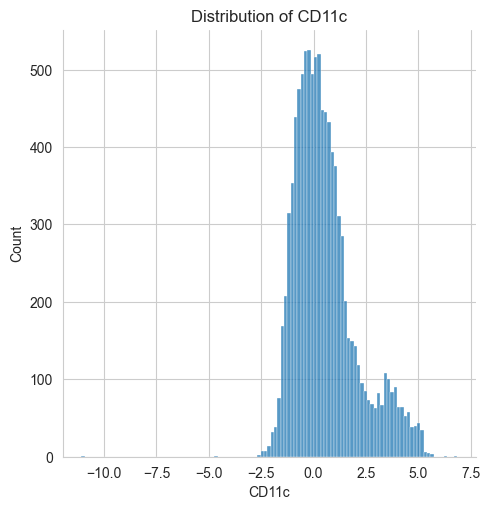

In [20]:
for column in fc_data.columns:
    sns.displot(fc_data[column])
    plt.title(f'Distribution of {column}')
    plt.show()

Hi! I will give you some basic summary of your  dataset. 
   Shape: 10000 rows x 9 columns 


***** Data Types in Columns *****
FSC-A     float64
SSC-A     float64
HLA-DR    float64
CD3       float64
CD45      float64
CD14      float64
CD56      float64
CD19      float64
CD11c     float64




***** Main Statistics on Categorical Columns ***** 
Empty DataFrame
Columns: [counts, frequencies]
Index: []

***** Descriptive Statistics for Numerical Columns *****
              min        max      mean       std    median       mad  \
FSC-A    0.144786  42.954485  0.962458  0.500012  0.908574  0.189098   
SSC-A    0.021657  15.460997  0.165415  0.190773  0.130543  0.072095   
HLA-DR  -7.634172  12.946668  1.791579  2.027281  1.194313  1.718664   
CD3     -2.517639  13.844391  3.280391  2.112079  4.373660  1.882302   
CD45    -8.329666  13.710922  5.169845  0.518247  5.234119  0.342594   
CD14    -8.833883   6.294236  1.097182  1.375876  0.672853  0.879185   
CD56   -12.358701   6.461899  0.412

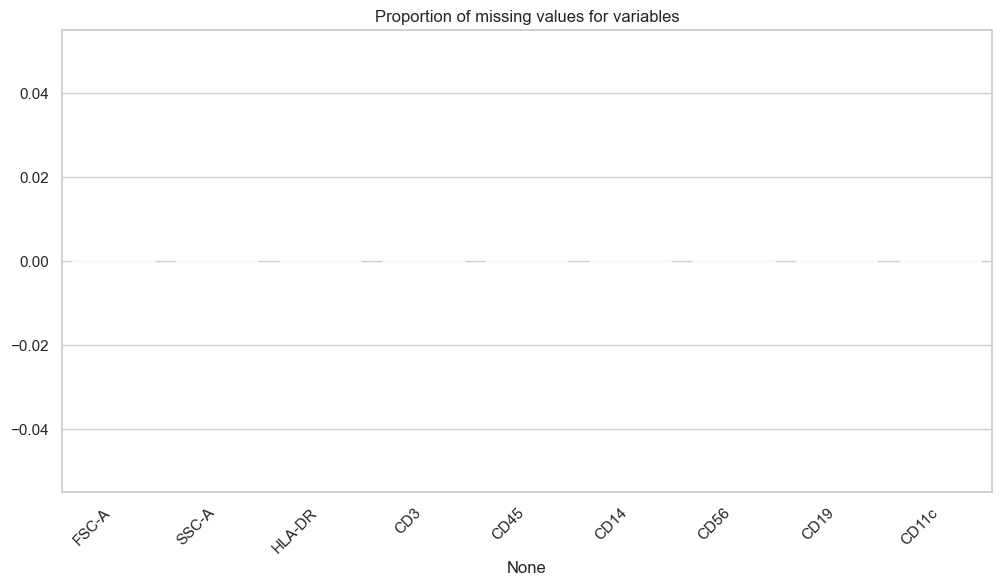

Quantity of  rows with missing values: 0
Columns with missing values: []
Duplicate rows in df: 0


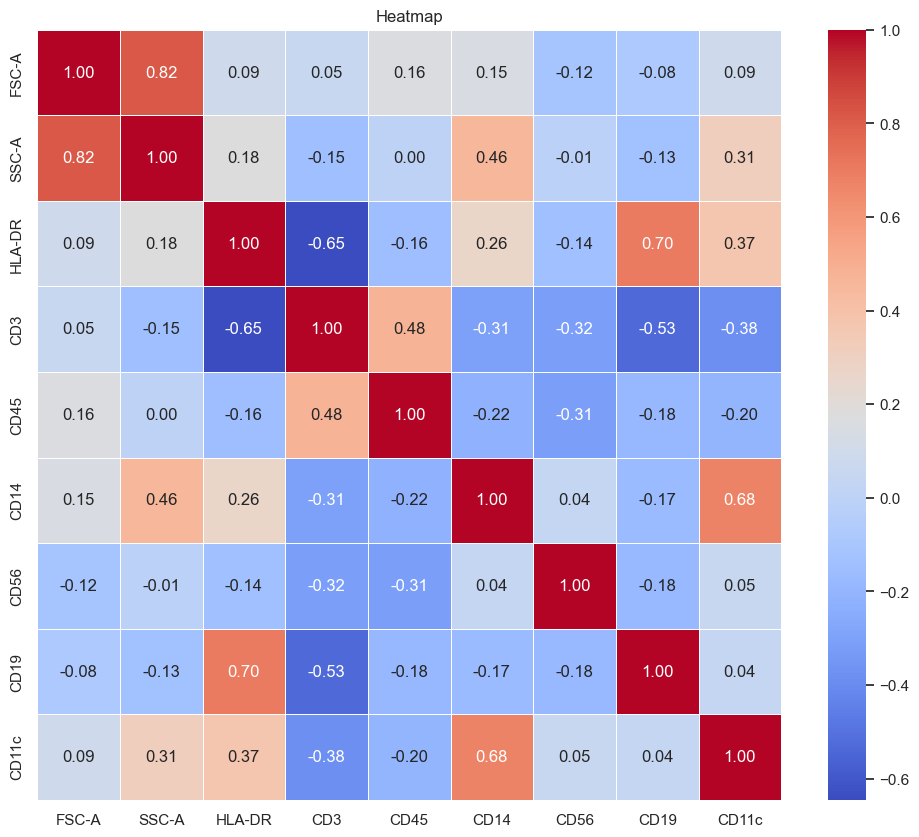

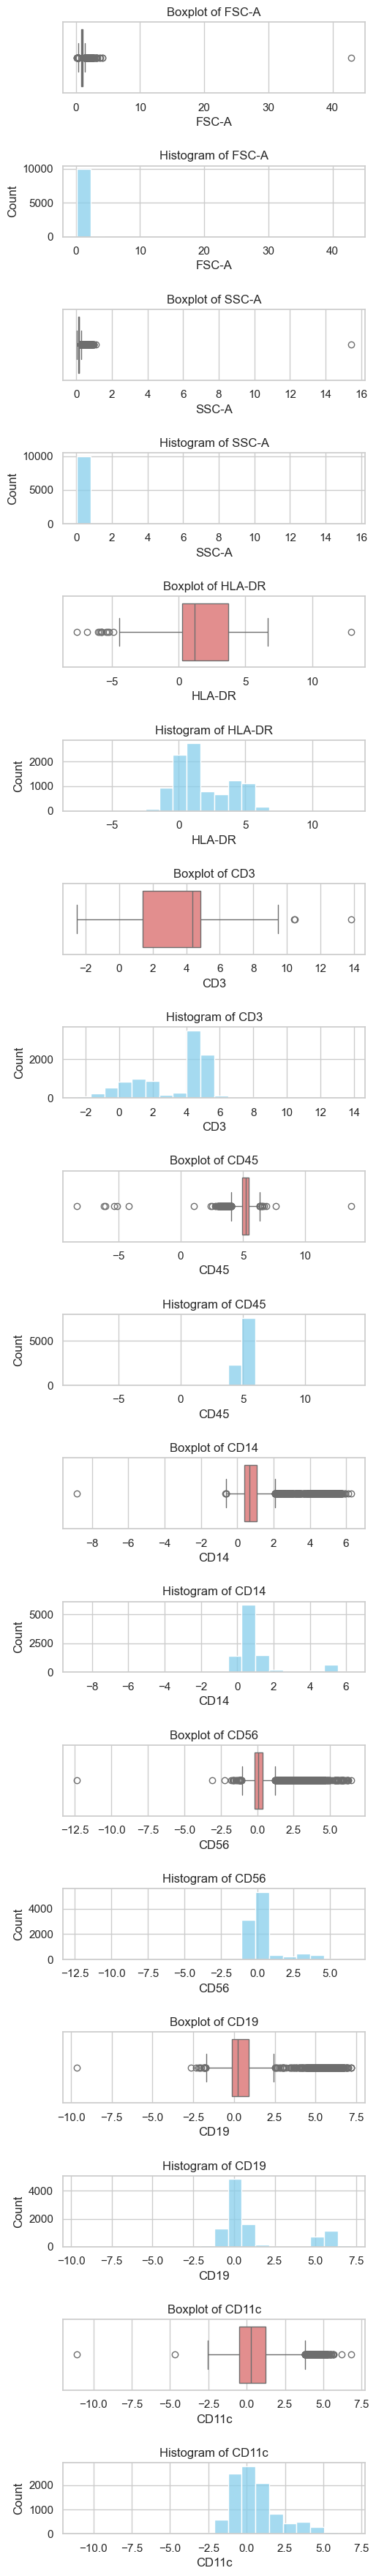

In [21]:
run_eda(fc_data)

Есть явные выбросы у хорошо коррелирующих между собой для FSC-A и SSC-A

In [22]:
#удаляем    выброс
fc_data = fc_data[fc_data['FSC-A']<10]
fc_data.shape


(9999, 9)

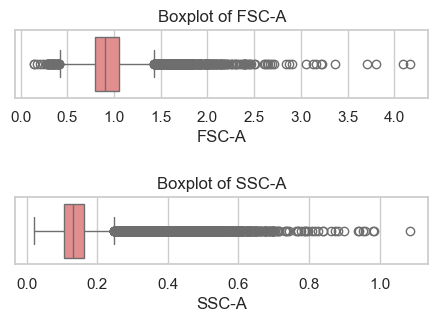

In [23]:
#проверяем удалился ли он для  обоих признаков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4))
fig.tight_layout(pad=4.0)

sns.boxplot(x=fc_data['FSC-A'], ax=axes[0], color="lightcoral")
axes[0].set_title(f'Boxplot of FSC-A')

sns.boxplot(x=fc_data['SSC-A'], ax=axes[1], color="lightcoral")
axes[1].set_title(f'Boxplot of SSC-A')

plt.show()

Это действительно так, осталось удлаить еще подозрительные точки по CD3 и HLA-DR

In [24]:
#удаляем    выброс
fc_data = fc_data[fc_data['CD3']<10]
fc_data = fc_data[fc_data['HLA-DR']>-4.5]
fc_data.shape


(9988, 9)

Hi! I will give you some basic summary of your  dataset. 
   Shape: 9988 rows x 9 columns 


***** Data Types in Columns *****
FSC-A     float64
SSC-A     float64
HLA-DR    float64
CD3       float64
CD45      float64
CD14      float64
CD56      float64
CD19      float64
CD11c     float64




***** Main Statistics on Categorical Columns ***** 
Empty DataFrame
Columns: [counts, frequencies]
Index: []

***** Descriptive Statistics for Numerical Columns *****
             min       max      mean       std    median       mad       25%  \
FSC-A   0.144786  4.164550  0.956738  0.266480  0.908444  0.182415  0.798567   
SSC-A   0.021657  1.085003  0.163638  0.113730  0.130487  0.069478  0.105533   
HLA-DR -4.467154  6.678981  1.798920  2.009167  1.196001  1.713041  0.278146   
CD3    -2.517639  8.703911  3.272571  2.100760  4.372014  1.878687  1.400230   
CD45    1.070088  6.848475  5.175450  0.431910  5.234223  0.334377  4.923100   
CD14   -0.643408  6.294236  1.097105  1.372654  0.671726  0.

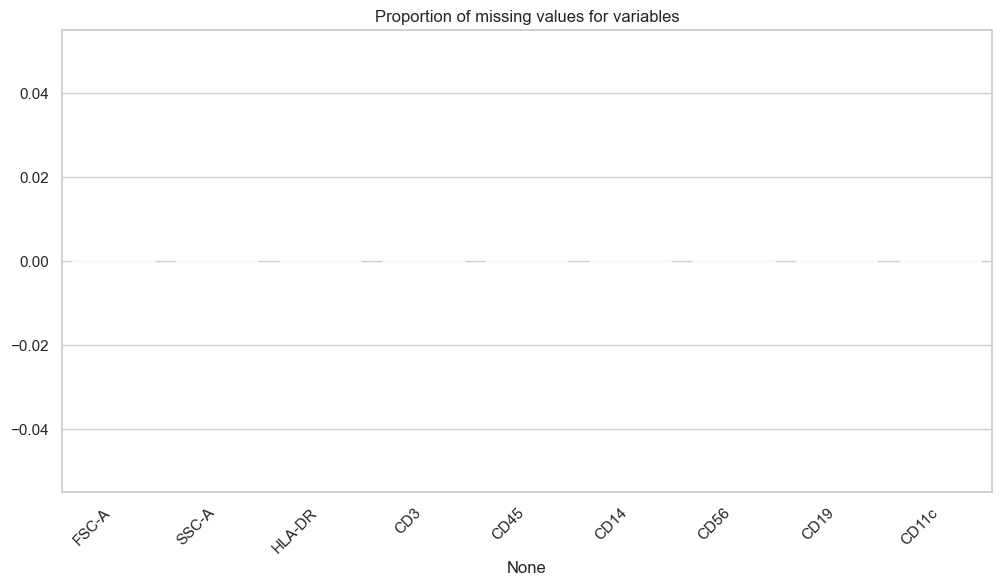

Quantity of  rows with missing values: 0
Columns with missing values: []
Duplicate rows in df: 0


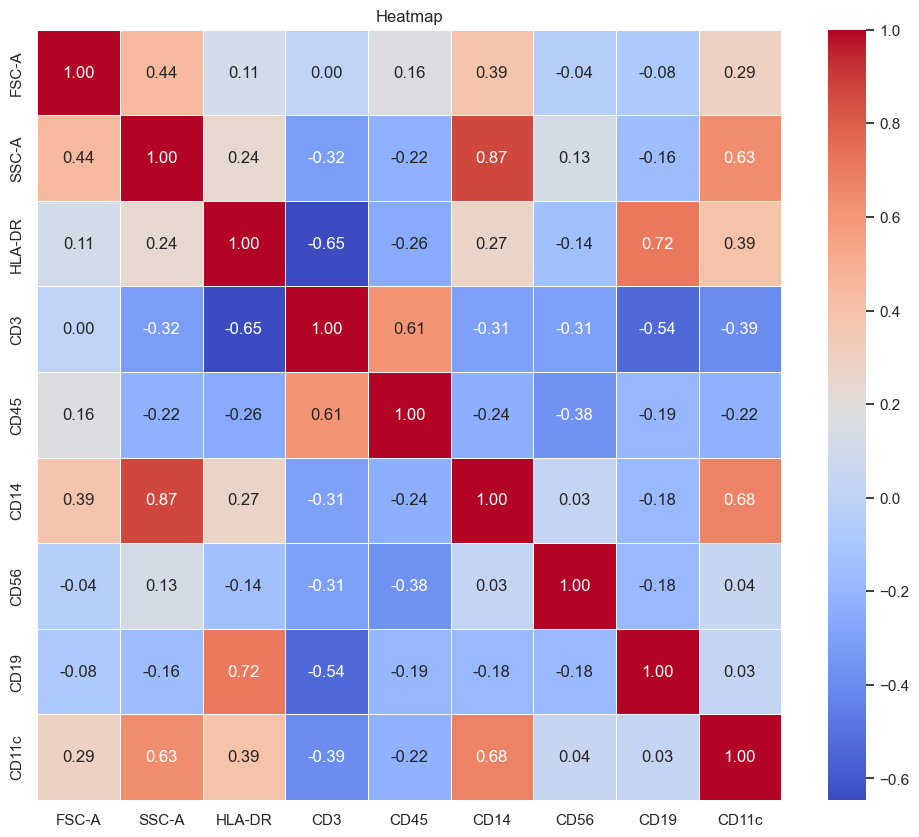

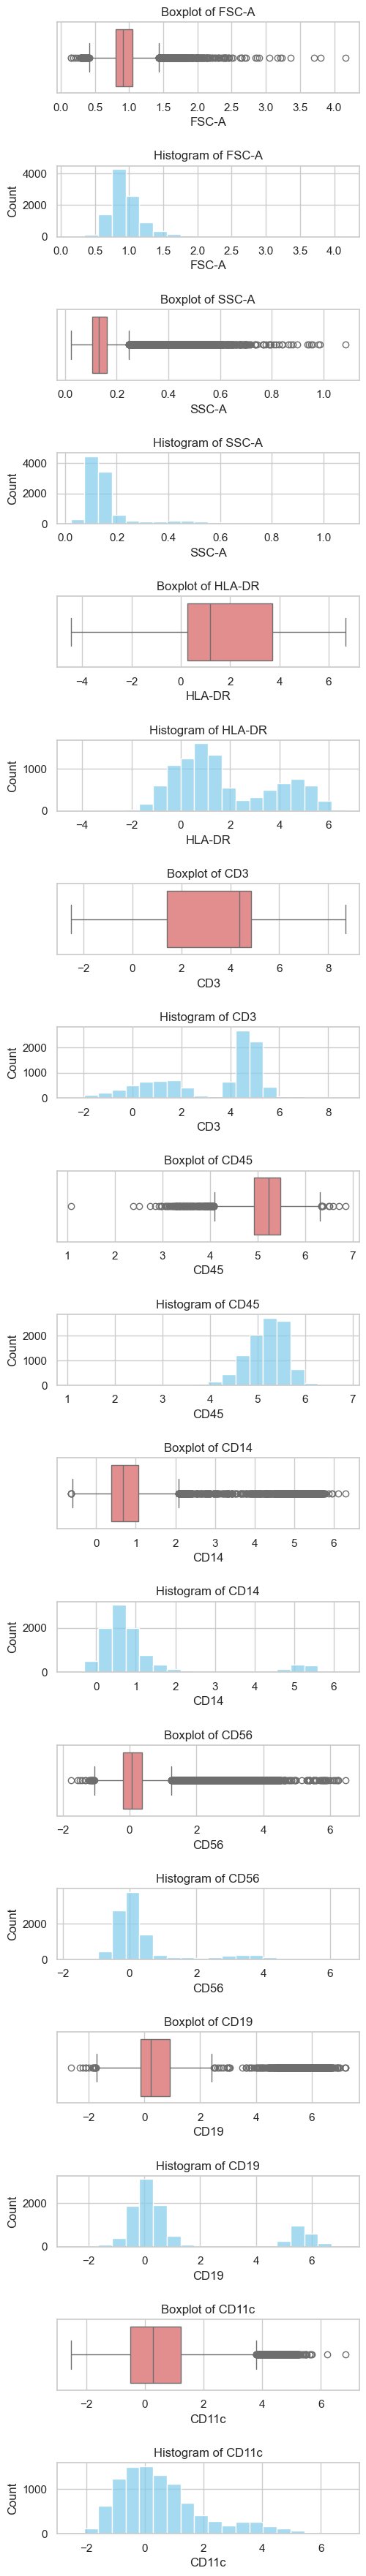

In [25]:
run_eda(fc_data)

Есть еще некая часть данных, котроая лежит вне 1.5IQR, однако мы не можем быть уверены, что это выбросы поэтому их лучше оставить

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [26]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity:
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """

    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа,
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными

    return tsne_embedding

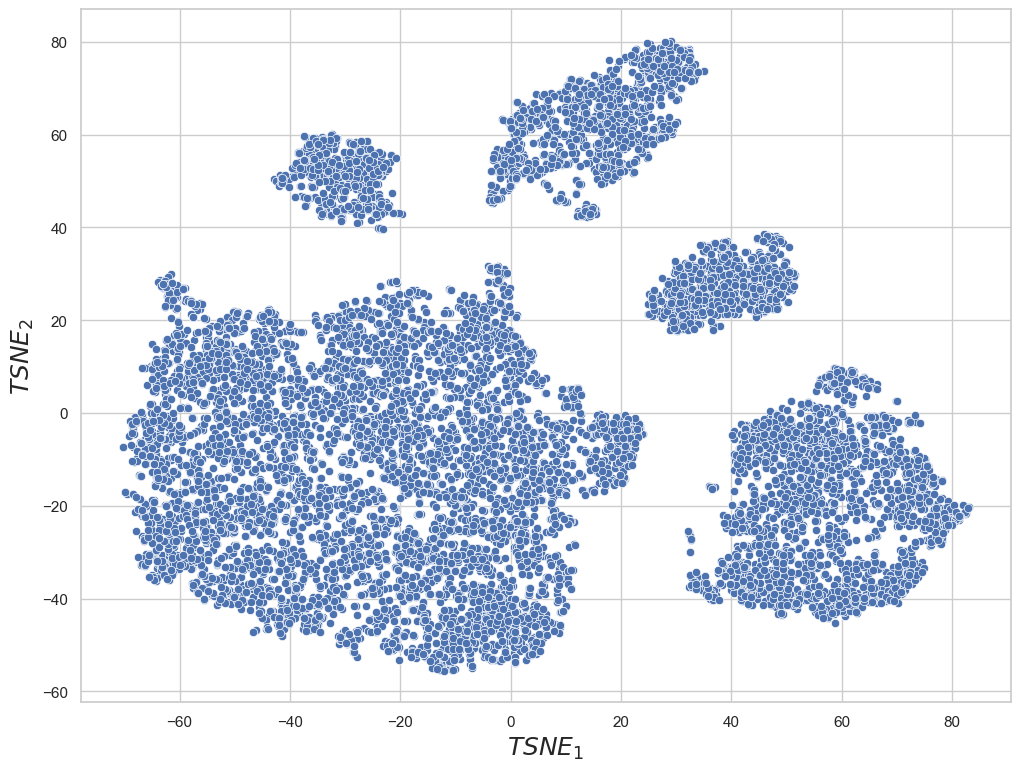

In [27]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

##### 1. Иерархическая кластеризация

In [28]:
def algorithm_selection_AgglomerativeClustering(X, distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
                        algorithms = ['average', 'single', 'complete']):

    rows_list = []
    for metric_dist in distances:
        for linkage in algorithms:
            clustering = AgglomerativeClustering(n_clusters=4, metric=metric_dist,linkage=linkage).fit(X)
            y_pred = clustering.labels_

            s_s = silhouette_score(X, y_pred,metric=metric_dist)

            rows_list.append([metric_dist,linkage,s_s])

    compare_dataframe = pd.DataFrame(rows_list, columns=['distance', 'linkage', 'silhouette'])

    return compare_dataframe

In [29]:
compare_dataframe=algorithm_selection_AgglomerativeClustering(fc_data)
compare_dataframe.sort_values(['silhouette'], ascending=False)

distance   linkage  silhouette
12     cosine   average    0.848746
14     cosine  complete    0.838902
2   euclidean  complete    0.614452
8          l2  complete    0.614452
3          l1   average    0.611092
9   manhattan   average    0.611092
5          l1  complete    0.594979
11  manhattan  complete    0.594979
0   euclidean   average    0.582366
6          l2   average    0.582366
1   euclidean    single    0.142302
7          l2    single    0.142302
4          l1    single    0.119087
10  manhattan    single    0.119087
13     cosine    single    0.037219

In [30]:
clustering = AgglomerativeClustering(n_clusters=5, metric='cosine',linkage='average').fit(fc_data)
y_pred = clustering.labels_

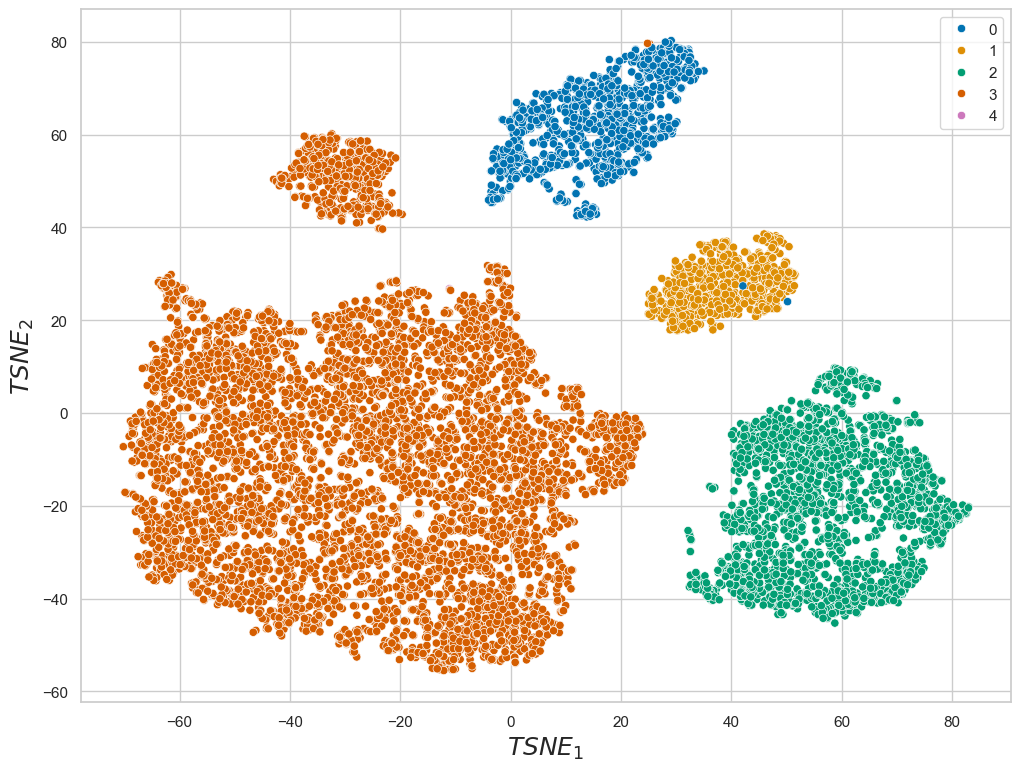

In [31]:
ierarch_clust__res = plot_tsne(fc_data, color=y_pred)

##### 2. K-means кластеризация

In [32]:
def algorithm_selection_KMeans(X, inits = ['k-means++', 'random'],
                        max_iter = [100, 200, 300],
                        algorithms=['lloyd', 'elkan']):

    rows_list = []
    for init in inits:
        for iter_n in max_iter:
            for algorithm in algorithms:
                clustering = KMeans(n_clusters=4, init=init,max_iter=iter_n,algorithm=algorithm).fit(X)
                y_pred = clustering.labels_

                s_s = silhouette_score(X, y_pred)

                rows_list.append([init,iter_n,algorithm,s_s])

    compare_dataframe = pd.DataFrame(rows_list, columns=['inits', 'max_iter', 'algorithm','silhouette'])

    return compare_dataframe

In [33]:
compare_dataframe=algorithm_selection_KMeans(fc_data)
compare_dataframe.sort_values(['silhouette'], ascending=False)

inits  max_iter algorithm  silhouette
0   k-means++       100     lloyd    0.613291
2   k-means++       200     lloyd    0.613291
4   k-means++       300     lloyd    0.613291
5   k-means++       300     elkan    0.613291
6      random       100     lloyd    0.613291
7      random       100     elkan    0.613291
8      random       200     lloyd    0.613291
10     random       300     lloyd    0.613291
3   k-means++       200     elkan    0.613195
9      random       200     elkan    0.613195
11     random       300     elkan    0.613195
1   k-means++       100     elkan    0.613123

In [34]:
kmeans = KMeans(n_clusters=4, init='k-means++',max_iter=100,algorithm='lloyd').fit(fc_data)
y_pred=kmeans.labels_
silhouette_score(fc_data, y_pred)

0.6131948001467499

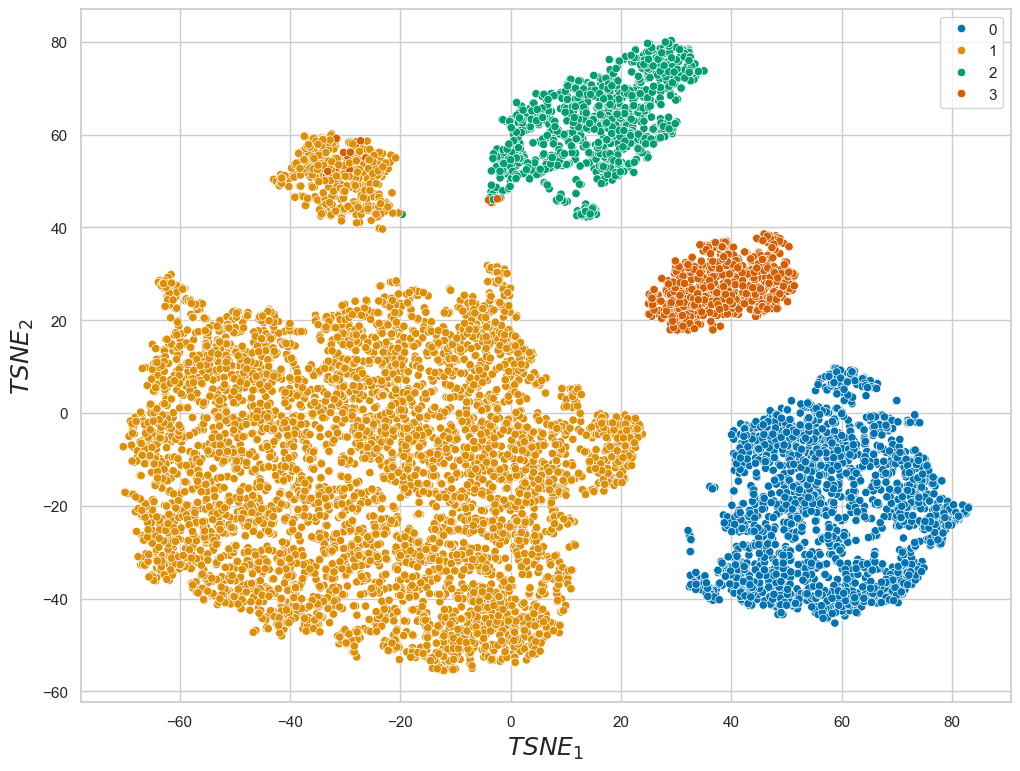

In [35]:
kmean_res = plot_tsne(fc_data, color=y_pred)

##### 3. DBSCAN кластеризация

In [36]:
def algorithm_selection_DBSCAN(X, min_samples = [5,10,15],
                        eps = [1,1.5,2],
                        distances = ['euclidean', 'l1', 'l2', 'manhattan'],
                        algorithms=['auto', 'ball_tree', 'kd_tree', 'brute']):

    rows_list = []
    for min_sample in min_samples:
        for e in eps:
            for metric in distances:
                for algorithm in algorithms:
                    clustering = DBSCAN(eps=e,min_samples=min_sample,metric=metric,algorithm=algorithm).fit(X)
                    y_pred = clustering.labels_

                    try:
                        s_s = silhouette_score(X, y_pred)
                    except:
                        s_s=-1

                    rows_list.append([min_sample,e,metric,algorithm,s_s])

    compare_dataframe = pd.DataFrame(rows_list, columns=['min_samples', 'eps', 'distances','algorithms','silhouette'])

    return compare_dataframe

In [37]:
compare_dataframe=algorithm_selection_DBSCAN(fc_data)
compare_dataframe.sort_values(['silhouette'], ascending=False)

min_samples  eps  distances algorithms  silhouette
130           15  2.0  euclidean    kd_tree    0.598308
128           15  2.0  euclidean       auto    0.598308
139           15  2.0         l2      brute    0.598308
138           15  2.0         l2    kd_tree    0.598308
137           15  2.0         l2  ball_tree    0.598308
..           ...  ...        ...        ...         ...
7              5  1.0         l1      brute   -0.550127
6              5  1.0         l1    kd_tree   -0.550127
5              5  1.0         l1  ball_tree   -0.550127
4              5  1.0         l1       auto   -0.550127
14             5  1.0  manhattan    kd_tree   -0.550127

[144 rows x 5 columns]

In [38]:
kmeans = DBSCAN(eps=2,min_samples=15,metric='euclidean',algorithm='auto').fit(fc_data)
y_pred=kmeans.labels_
silhouette_score(fc_data, y_pred)

0.5983083750988026

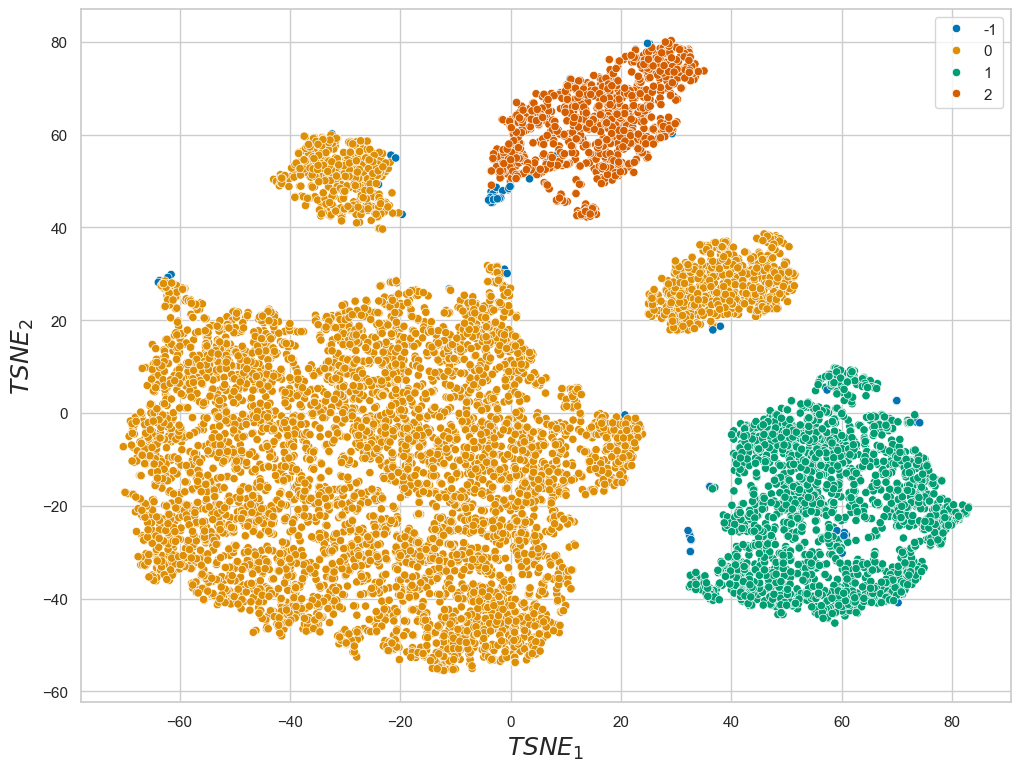

In [39]:
tsne_res = plot_tsne(fc_data, color=y_pred)

Лучший результат удалось получить для иерархической кластеризация (по картинке и silhouette score). При этом silhouette score у dbscan и  k-means явно демонстрирует, что важно опираться не только на одну метрику. В частности silhouette score может давать неправильные оценки для кластеров с различными плотностями или формами.

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один

---

цвет?

Везде удалось получить отдельные группы, покаршенные в один цвет. При этом две самые левые группы точек красятся в один кластер, что говорит нам о 4 типах клеток (а не пяти)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

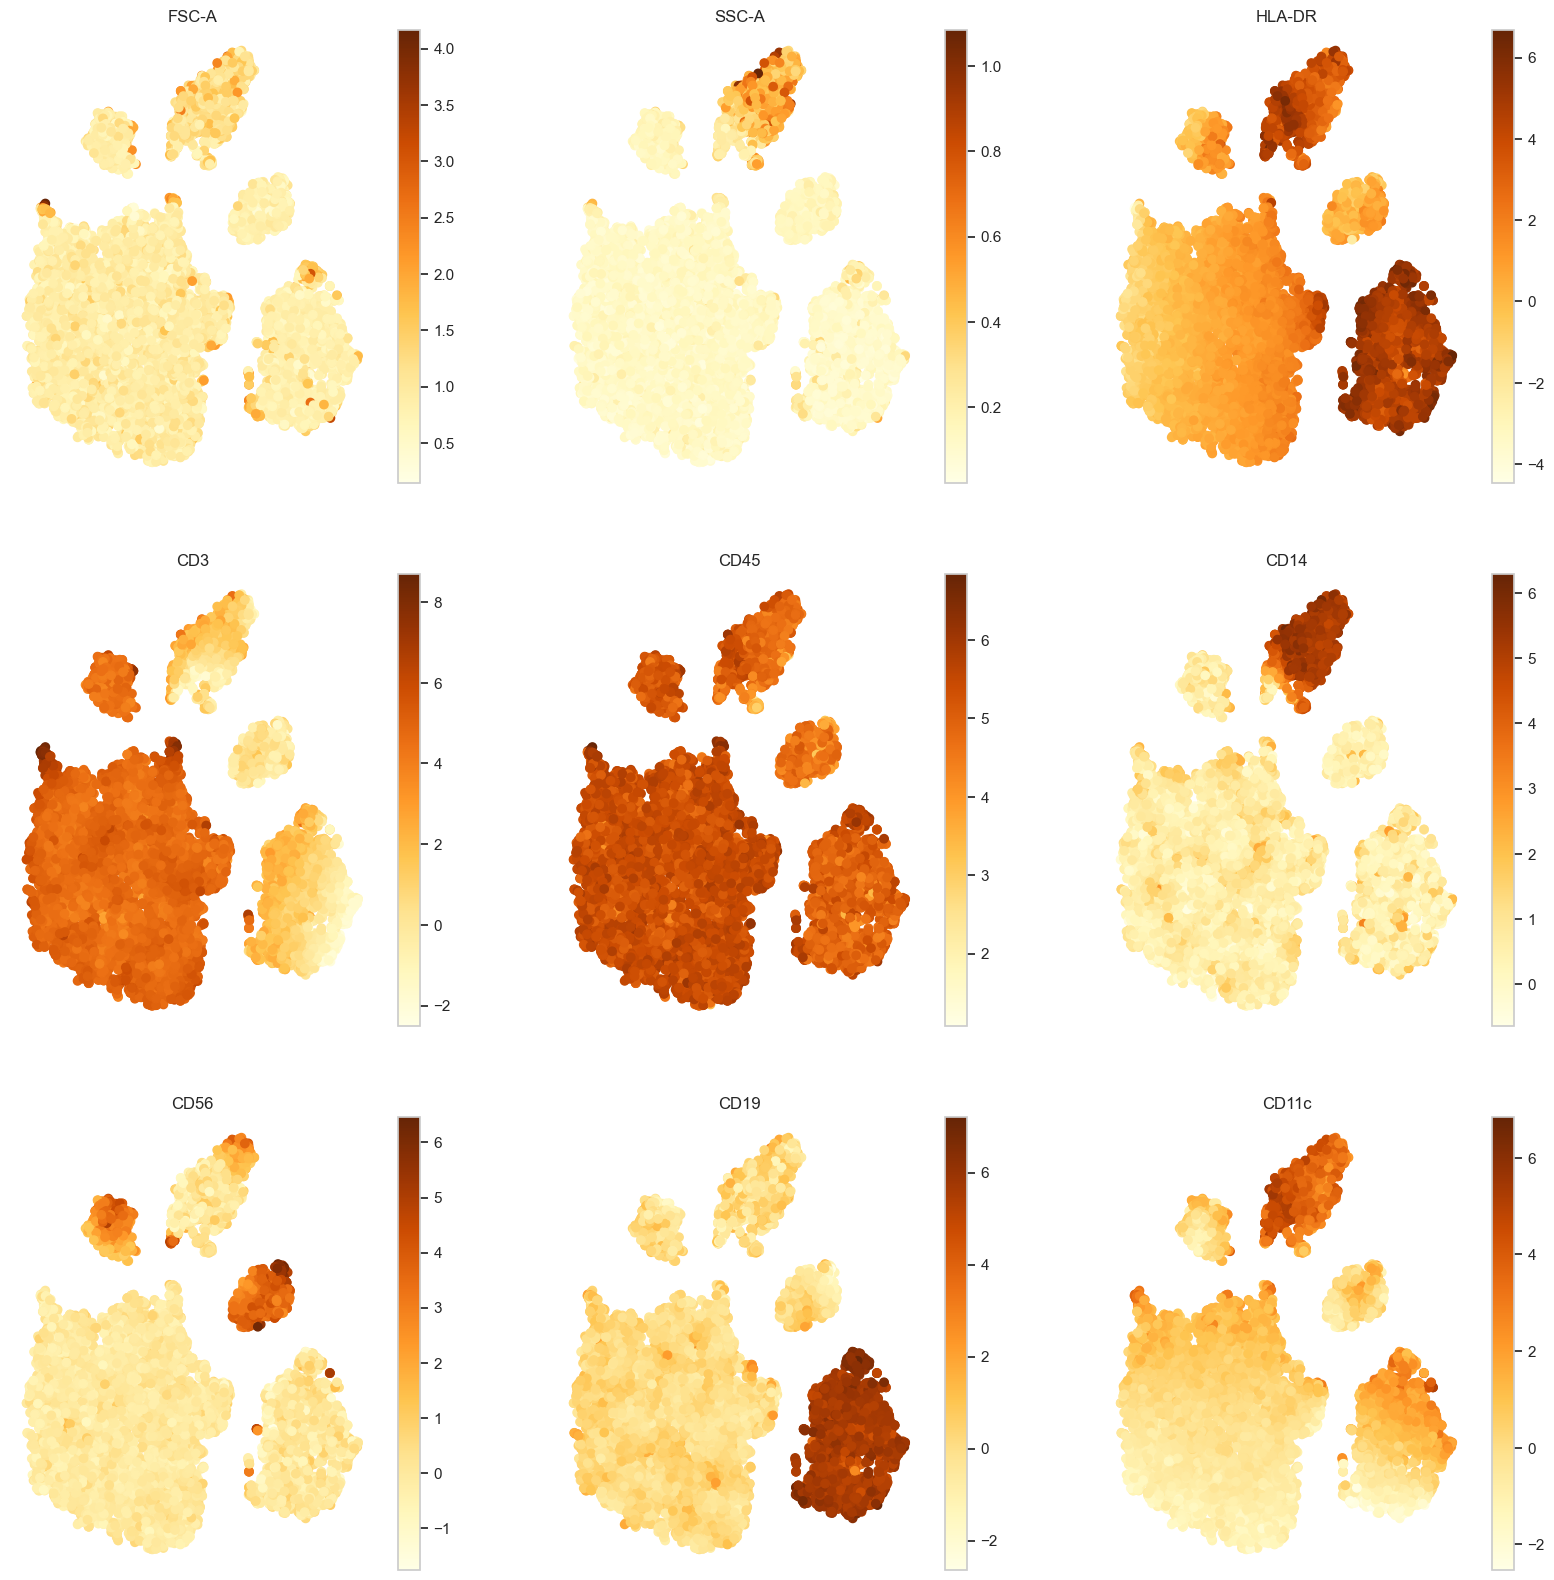

In [40]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1],
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [41]:
cell_type_cluster_map = {0: "Monocytes",
                         1: "Other cells",
                         2: "B_cells",
                         3: "T_cells",
                         4: "Other cells"}

In [42]:
clustering = AgglomerativeClustering(n_clusters=5, metric='cosine',linkage='average').fit(fc_data)
y_pred = clustering.labels_

In [43]:
labeled_fc_data = fc_data.assign(Population=clustering.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [44]:
labeled_fc_data.groupby(['Population'])['Population'].count()

Population
B_cells        2035
Monocytes      1100
Other cells     633
T_cells        6220
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [45]:
labeled_fc_data.to_csv('labeled_fc_data.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [46]:
X = labeled_fc_data.drop(['Population'], axis=1)
y = labeled_fc_data['Population']
#обязательно ставим stratify, чтобы и в train и в test было одинаковое распределение классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

TRAIN
Accuracy: 1.00
f1_score: 1.00
TEST
Accuracy: 1.00
f1_score: 1.00


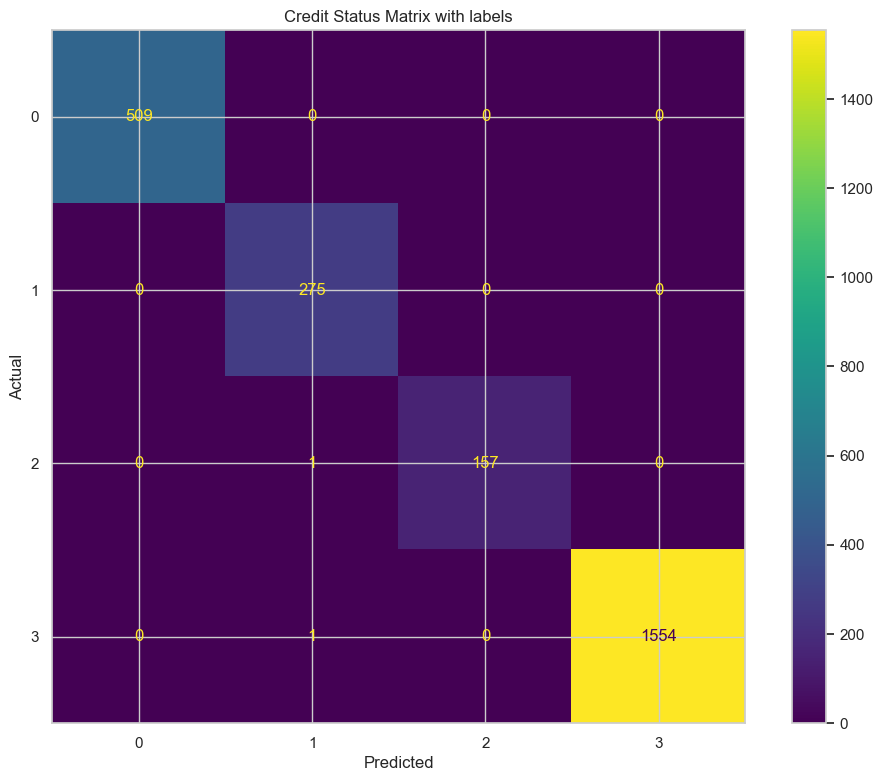

In [47]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

train_predictions = model.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show()

TRAIN
Accuracy: 1.00
f1_score: 1.00
TEST
Accuracy: 1.00
f1_score: 1.00


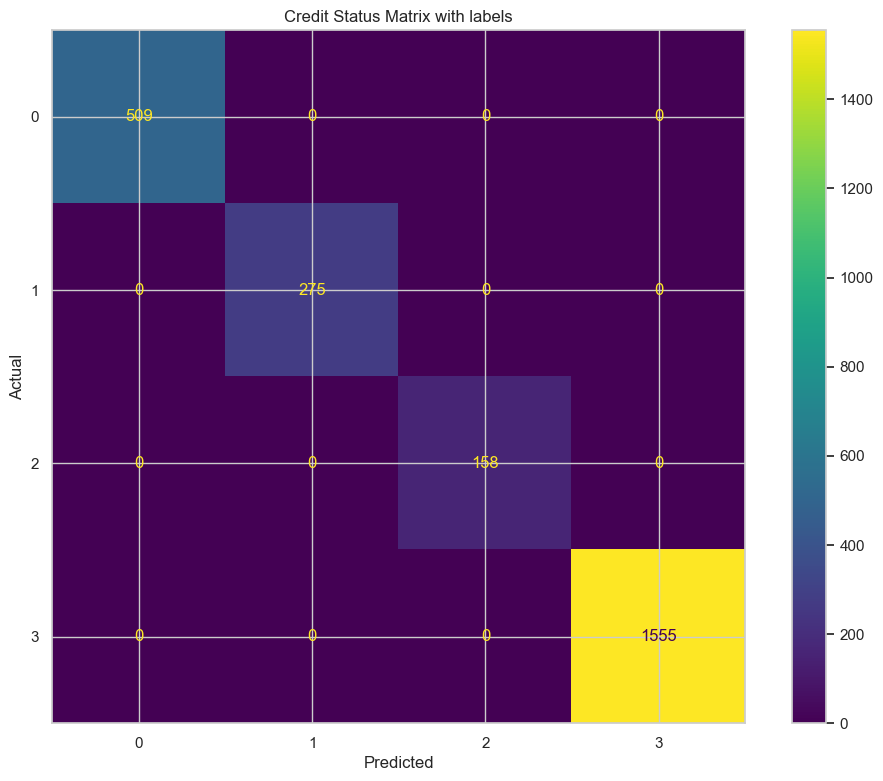

In [48]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

train_predictions = model.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show()

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Хотелось бы побывать в ОАЭ - посмотреть на страну, небоскребы, фонтаны, океан. И на город, который смог так вырасти всего за 30 лет.

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Интересное дз, круто что уже удалось поработать с клетками. Правда, перед выполнением хотелось бы побольше узнать про метрики, ограниченность их применения (и про разные настройки каждого алгоритма - тоже)